In [2]:
import json
import random
import math
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

FILE_NAME = 'model.json'


class Sample:
    def __init__(self, input, expected):
        self.input = input
        self.expected = expected

    def show(self):
        plt.imshow(self.input.reshape(28, 28), cmap='gray')
        plt.show()


def combine_samples(samples):
    inpt = np.array([x.input for x in samples]).transpose()
    expect = np.array([x.expected for x in samples]).transpose()
    return Sample(inpt, expect)


def get_samples(train):
    samples = []
    x_train, t_train, x_test, t_test = mnist_load()
    if train:
        data = zip(x_train, t_train)
    else:
        data = zip(x_test, t_test)
    for x, y in data:
        one_hot = np.array([int(i == y) for i in range(10)])
        samples.append(Sample(np.vectorize(lambda x: x / 255)(x), one_hot))
    return samples


def mnist_load():
    with open("mnist/mnist.pkl", "rb") as f:
        mnist = pickle.load(f)
    return (
        mnist["training_images"],
        mnist["training_labels"],
        mnist["test_images"],
        mnist["test_labels"],
    )


def show_random_wrong_sample(score):
    wrong = []
    for pred in score.predictions:
        if pred.sample.expected.argmax() != pred.prediction.argmax():
            wrong.append(pred)
    w = wrong[random.randint(0, len(wrong))]
    print('Expected: ', w.sample.expected.argmax())
    print('Got: ', w.prediction.argmax())
    w.sample.show()


class Prediction:
    def __init__(self, sample, prediction):
        self.sample = sample
        self.prediction = prediction


class ScoreResult:
    def __init__(self, accuracy, loss, predictions):
        self.accuracy = accuracy
        self.loss = loss
        self.predictions = predictions

    def __str__(self):
        return f"accuracy: {self.accuracy * 100}%\n loss: {self.loss}"


class RunResult:
    def __init__(self, activations, weighted_inputs):
        self.activations = activations
        self.weighted_inputs = weighted_inputs

In [3]:
train_data = get_samples(True)
test_data = get_samples(False)

In [4]:
class SGD():
    def __init__(self, lr=0.01):
        self.lr = lr

    def init_params(self, model):
        self.model = model

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.model.weights[i] -= self.lr * grad_w[i]
            self.model.biases[i] -= self.lr * grad_b[i]

In [5]:
class Momentum():
    def __init__(self, lr=0.01, momentum=0.6):
        self.m = momentum
        self.lr = lr

    def init_params(self, model):
        self.model = model

        self.velocity_w = [None]
        self.velocity_b = [None]
        for i in range(1, len(self.model.layers)):
            self.velocity_w.append(np.zeros_like(self.model.weights[i]))
            self.velocity_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * grad_w[i]
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * grad_b[i]
            self.model.weights[i] -= self.velocity_w[i]
            self.model.biases[i] -= self.velocity_b[i]

In [6]:
class Nesterov():
    def __init__(self, lr=0.01, momentum=0.6):
        self.m = momentum
        self.lr = lr

    def init_params(self, model):
        self.model = model

        self.velocity_w = [None]
        self.velocity_b = [None]
        for i in range(1, len(self.model.layers)):
            self.velocity_w.append(np.zeros_like(self.model.weights[i]))
            self.velocity_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        model_ahead = deepcopy(self.model)

        for i in range(1, len(model_ahead.layers)):
            model_ahead.weights[i] -= self.m * self.velocity_w[i]
            model_ahead.biases[i] -= self.m * self.velocity_b[i]

        result = model_ahead.run(batch)
        errors = model_ahead.backprop(batch, result)
        grad_ahead_w, grad_ahead_b = model_ahead.calculate_grad(result.activations, errors)

        for i in range(1, len(model_ahead.layers)):
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * grad_ahead_w[i]
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * grad_ahead_b[i]

            self.model.weights[i] -= self.velocity_w[i]
            self.model.biases[i] -= self.velocity_b[i]

In [7]:
class AdaGrad():
    def __init__(self, lr=1):
        self.lr = lr
        self.eps = 1e-10

    def init_params(self, model):
        self.model = model

        self.N_w = [None]
        self.N_b = [None]
        for i in range(1, len(self.model.layers)):
            self.N_w.append(np.zeros_like(self.model.weights[i]))
            self.N_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.N_w[i] += grad_w[i] ** 2
            self.N_b[i] += grad_b[i] ** 2

            self.model.weights[i] -= self.lr * grad_w[i] / (np.sqrt(self.N_w[i]) + self.eps)
            self.model.biases[i] -= self.lr * grad_b[i] / (np.sqrt(self.N_b[i]) + self.eps)

In [8]:
class RMSprop():
    def __init__(self, lr=0.01, decay=0.9):
        self.lr = lr
        self.decay = decay
        self.eps = 1e-10

    def init_params(self, model):
        self.model = model

        self.N_w = [None]
        self.N_b = [None]
        for i in range(1, len(self.model.layers)):
            self.N_w.append(np.zeros_like(self.model.weights[i]))
            self.N_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.N_w[i] = self.decay * self.N_w[i] + (1 - self.decay) * grad_w[i] ** 2
            self.N_b[i] = self.decay * self.N_b[i] + (1 - self.decay) * grad_b[i] ** 2

            self.model.weights[i] -= self.lr * grad_w[i] / (np.sqrt(self.N_w[i]) + self.eps)
            self.model.biases[i] -= self.lr * grad_b[i] / (np.sqrt(self.N_b[i]) + self.eps)

In [9]:
class AdaDelta():
    def __init__(self, lr=0.01, decay=0.9):
        self.lr = lr
        self.decay = decay
        self.eps = 1e-10

    def init_params(self, model):
        self.model = model

        self.N_w = [None]
        self.N_b = [None]

        self.P_w = [None]
        self.P_b = [None]
        for i in range(1, len(self.model.layers)):
            self.N_w.append(np.zeros_like(self.model.weights[i]))
            self.N_b.append(np.zeros_like(self.model.biases[i]))

            self.P_w.append(np.zeros_like(self.model.weights[i]))
            self.P_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.N_w[i] = self.decay * self.N_w[i] + (1 - self.decay) * grad_w[i] ** 2
            self.N_b[i] = self.decay * self.N_b[i] + (1 - self.decay) * grad_b[i] ** 2

            d_w = grad_w[i] * np.sqrt(self.P_w[i] + self.eps) / np.sqrt(self.N_w[i] + self.eps)
            d_b = grad_b[i] * np.sqrt(self.P_b[i] + self.eps) / np.sqrt(self.N_b[i] + self.eps)

            self.P_w[i] = self.decay * self.P_w[i] + (1 - self.decay) * d_w ** 2
            self.P_b[i] = self.decay * self.P_b[i] + (1 - self.decay) * d_b ** 2
            self.model.weights[i] -= self.lr * d_w
            self.model.biases[i] -= self.lr * d_b

In [10]:
class Adam():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-10

    def init_params(self, model):
        self.model = model

        self.M_w = [None]
        self.M_b = [None]

        self.N_w = [None]
        self.N_b = [None]
        for i in range(1, len(self.model.layers)):
            self.M_w.append(np.zeros_like(self.model.weights[i]))
            self.M_b.append(np.zeros_like(self.model.biases[i]))

            self.N_w.append(np.zeros_like(self.model.weights[i]))
            self.N_b.append(np.zeros_like(self.model.biases[i]))

    def step(self, grad_w, grad_b, batch):
        t = self.model.current_epoch + 1
        for i in range(1, len(self.model.layers)):
            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * grad_w[i]
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * grad_b[i]

            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * grad_w[i] ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * grad_b[i] ** 2

            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)

            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)

            self.model.weights[i] -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            self.model.biases[i] -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

In [11]:
class Network:
    def __init__(self, layers, optimizer, batch_size):
        self.current_epoch = 0
        self.layers = layers
        self.weights = [None]
        self.biases = [None]
        self.batch_size = batch_size
        for i in range(1, len(layers)):
            self.weights.append(np.random.uniform(-1, -1, (layers[i], layers[i - 1])) * np.sqrt(1 / layers[i - 1]))
            self.biases.append(np.random.uniform(-1, 1, layers[i]))
        self.optimizer = optimizer
        optimizer.init_params(self)

    def dump(self, path):
        d = {
            "layers": self.layers,
            "weights": [x.tolist() for x in self.weights[1:]],
            "biases": [x.tolist() for x in self.biases[1:]],
        }
        with open(path, 'w') as f:
            json.dump(d, f)

    def load(self, path):
        with open(path, 'r') as f:
            d = json.load(f)
        self.layers = d["layers"]
        self.weights = [None] + [np.array(x) for x in d["weights"]]
        self.biases = [None] + [np.array(x) for x in d["biases"]]

    def train(self, samples, epochs, monitor_dataset=None):
        samples_copy = samples[:]
        res = []
        for epoch in range(epochs):
            self.current_epoch += 1
            random.shuffle(samples_copy)
            for i in range(0, len(samples_copy), self.batch_size):
                batch = combine_samples(samples_copy[i:i + self.batch_size])
                result = self.run(batch)
                errors = self.backprop(batch, result)
                grad_w, grad_b = self.calculate_grad(result.activations, errors)
                self.optimizer.step(grad_w, grad_b, batch)
            if monitor_dataset is not None:
                score = self.score(monitor_dataset)
                res.append(score)
        return res

    def run(self, sample):
        activations = [None for _ in self.layers]
        activations[0] = sample.input
        weighted_inputs = [None for _ in self.layers]
        for i in range(1, len(self.layers)):
            weighted_inputs[i] = self.weights[i] @ activations[i - 1] + self.biases[i].reshape(self.layers[i], 1)
            activations[i] = self.calc_activation(weighted_inputs[i])
        return RunResult(activations, weighted_inputs)

    def backprop(self, sample, result):
        errors = [None for _ in self.layers]
        errors[-1] = self.calc_delta(sample.expected, result.activations[-1])
        for i in reversed(range(1, len(self.layers) - 1)):
            errors[i] = (
                    (np.transpose(self.weights[i + 1]) @ errors[i + 1])
                    * self.calc_activation_derivative(result.weighted_inputs[i])
            )
        return errors

    def calculate_grad(self, activations, errors):
        grad_w = [None]
        grad_b = [None]
        for i in range(1, len(self.layers)):
            grad_w.append(errors[i] @ activations[i - 1].transpose() / self.batch_size)
            grad_b.append(errors[i].sum(axis=1) / self.batch_size)
        return grad_w, grad_b

    def score(self, samples):
        cost = 0
        accurate = 0
        predictions = []
        for sample in samples:
            res = self.run(combine_samples([sample]))
            out = res.activations[-1][:, 0]
            pred = Prediction(sample, out)
            predictions.append(pred)
            cost += self.calc_cost(sample.expected, out)
            if out.argmax() == sample.expected.argmax():
                accurate += 1
        return ScoreResult(accurate / len(samples), cost / len(samples), predictions)

    def calc_cost(self, expected, out):
        return np.sum(np.nan_to_num(-expected * np.log(out)) - (1 - expected) * np.log(1 - out))

    def calc_delta(self, expected, activations):
        return (activations - expected)

    def calc_activation(self, x):
        return 1 / (1 + np.exp(-x))

    def calc_activation_derivative(self, x):
        return self.calc_activation(x) * (1 - self.calc_activation(x))

In [12]:
optimizers = [
    SGD(1),
    Momentum(0.1, 0.8),
    Nesterov(0.1, 0.8),
    AdaGrad(0.1),
    RMSprop(0.001, 0.9),
    AdaDelta(100),
    Adam(0.01, 0.9, 0.999),
]

EPOCHS = 20

scores = []
labels = ["SGD", "Momentum", "Nesterov", "AdaGrad", "RMSprop", "AdaDelta", "Adam"]

for i, optimizer in enumerate(optimizers):
    network = Network(layers=[784, 10, 10], optimizer=optimizer, batch_size=10)
    score = network.train(train_data, EPOCHS, monitor_dataset=test_data)
    scores.append(score)
    print(f"\n{labels[i]}\n {score[-1]}\n")


SGD
 accuracy: 90.55%
 loss: 0.6280686951188451


Momentum
 accuracy: 92.61%
 loss: 0.5142637109783553


Nesterov
 accuracy: 92.01%
 loss: 0.5443112326660302


AdaGrad
 accuracy: 91.67999999999999%
 loss: 0.5440028956672348


RMSprop
 accuracy: 91.97999999999999%
 loss: 0.6453698367761025


AdaDelta
 accuracy: 92.52%
 loss: 0.586258847295353


Adam
 accuracy: 92.19000000000001%
 loss: 0.5383409779731516



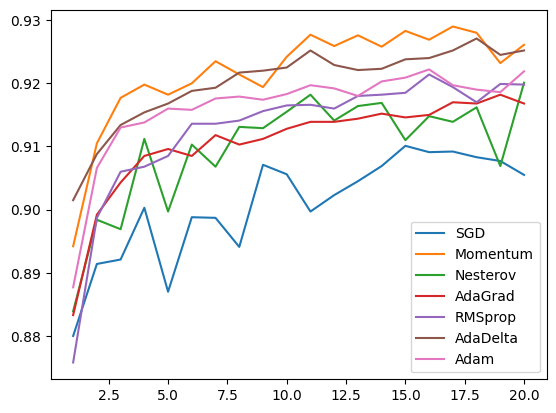

In [16]:
xs = list(range(1, EPOCHS + 1))
for i in range(len(optimizers)):
    ys = [x.accuracy for x in scores[i]]
    plt.plot(xs, ys)
plt.legend(labels)

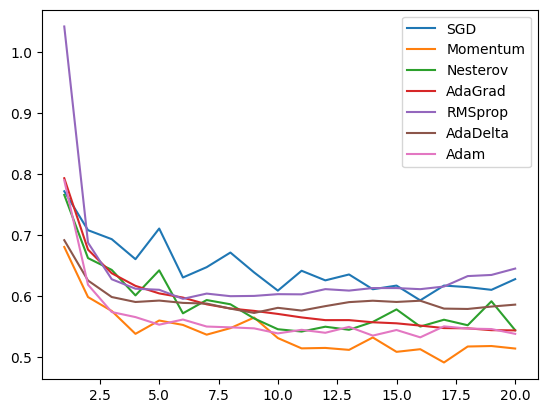

In [17]:
xs = list(range(1, EPOCHS + 1))
for i in range(len(optimizers)):
    ys = [x.loss for x in scores[i]]
    plt.plot(xs, ys)
plt.legend(labels)